In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


### Connect drive to Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Inspect our Input data for optimal preprocessing and optimal model selection

In [ ]:
# Identify Image Resolutions

# Import Packages
import os
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np
import seaborn as sns

#create a list of pcitures filepaths 
files = os.listdir('/content/drive/MyDrive/training_demo/images/train/')
#print(files)
image_list = []
for file in files:
  if file.endswith("jpg"):
    image_list.append("/content/drive/MyDrive/training_demo/images/train/" + file)
#print(image_list)
img_meta = {}
for f in image_list: img_meta[str(f)] = imagesize.get(f)


# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect_Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total Nr of Images in the dataset: 748


,FileName,Size,Width,Height,Aspect_Ratio
0,/content/drive/MyDrive/training_demo/images/tr...,"(1024, 1066)",1024,1066,0.96
1,/content/drive/MyDrive/training_demo/images/tr...,"(1024, 683)",1024,683,1.50
2,/content/drive/MyDrive/training_demo/images/tr...,"(1024, 818)",1024,818,1.25
3,/content/drive/MyDrive/training_demo/images/tr...,"(1024, 512)",1024,512,2.00
4,/content/drive/MyDrive/training_demo/images/tr...,"(1024, 576)",1024,576,1.78


In [ ]:
img_meta_df.describe()

,Width,Height,Aspect_Ratio
count,748.000000,748.000000,748.000000
mean,982.931818,1009.509358,1.059198
std,421.129846,488.869391,0.367355
min,164.000000,131.000000,0.460000
25%,640.000000,576.000000,0.750000
50%,1024.000000,1024.000000,1.000000
75%,1200.000000,1600.000000,1.330000
max,1920.000000,2400.000000,2.990000


Text(0, 0.5, 'Height')

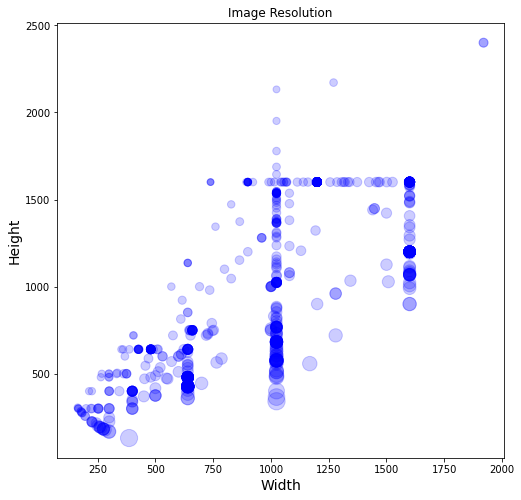

In [ ]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height,color='blue', s=img_meta_df["Aspect_Ratio"]*100, alpha=0.2, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

1009.50935828877
982.9318181818181


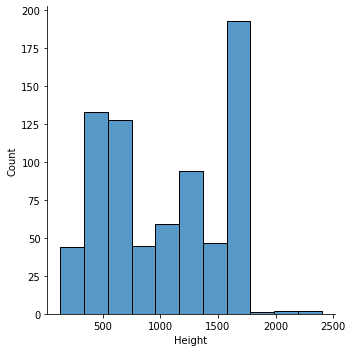

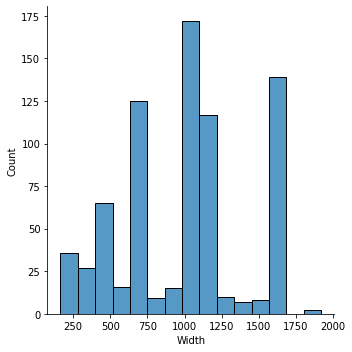

In [ ]:
#visualize Height/Width with countplot

sns.displot(x="Height", data=img_meta_df)
sns.displot(x="Width", data=img_meta_df)

print(img_meta_df.Height.mean())
print(img_meta_df.Width.mean())

In [ ]:
#create a df with differnt sizes and their count 
imgsize_count= img_meta_df.Size.value_counts().to_frame()

#get most most interesting sizes 
mask1= imgsize_count.Size >=5

imgsize_count.loc[mask1,:]

,Size
"(1200, 1600)",108
"(1600, 1200)",67
"(1600, 1600)",35
"(640, 480)",29
"(640, 427)",24
"(480, 640)",21
"(1024, 1024)",14
"(400, 400)",11
"(640, 640)",11
"(1024, 683)",10


In [ ]:
img_meta_df.loc[(img_meta_df.Height >= 1024) & (img_meta_df.Width >= 1024), :]

,FileName,Size,Width,Height,Aspect_Ratio
0,/content/drive/MyDrive/training_demo/images/tr...,"(1024, 1066)",1024,1066,0.96
9,/content/drive/MyDrive/training_demo/images/tr...,"(1024, 1024)",1024,1024,1.00
12,/content/drive/MyDrive/training_demo/images/tr...,"(1470, 1600)",1470,1600,0.92
13,/content/drive/MyDrive/training_demo/images/tr...,"(1200, 1600)",1200,1600,0.75
14,/content/drive/MyDrive/training_demo/images/tr...,"(1024, 1024)",1024,1024,1.00
...,...,...,...,...,...
620,/content/drive/MyDrive/training_demo/images/tr...,"(1024, 1536)",1024,1536,0.67
621,/content/drive/MyDrive/training_demo/images/tr...,"(1600, 1067)",1600,1067,1.50
622,/content/drive/MyDrive/training_demo/images/tr...,"(1600, 1200)",1600,1200,1.33
624,/content/drive/MyDrive/training_demo/images/tr...,"(1024, 1364)",1024,1364,0.75


More than half of our pictures have a very high resolution. The mean of width and height are also above 1000 ---> upgrade 512x512 model to 1024x1024 in order detect more details ??? etc. (The first model I used was a 512x512 Centernet)

## **Cloning TFOD 2.0 Github**

In [ ]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 67051, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 67051 (delta 8), reused 15 (delta 8), pack-reused 67035
Receiving objects: 100% (67051/67051), 576.29 MiB | 39.73 MiB/s, done.
Resolving deltas: 100% (47067/47067), done.


In [ ]:
pwd

'/content'

In [ ]:
cd /content/models/research

/content/models/research


In [ ]:
pwd

'/content/models/research'

In [ ]:
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git


Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 37.05 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [ ]:
cd cocoapi/PythonAPI

/content/models/research/cocoapi/PythonAPI


In [ ]:
!make

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/models/research/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/n

In [ ]:
cp -r pycocotools /content/models/research

### Install the Object Detection API

In [ ]:
cd /content/models/research

/content/models/research


In [ ]:
cp object_detection/packages/tf2/setup.py .

In [ ]:
!python -m pip install .

Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 9.9 MB 13.6 MB/s 
     |████████████████████████████████| 352 kB 84.9 MB/s 
     |████████████████████████████████| 1.8 MB 96.3 MB/s 
     |████████████████████████████████| 23.1 MB 1.1 MB/s 
     |████████████████████████████████| 47.7 MB 156 kB/s 
     |████████████████████████████████| 1.2 MB 69.7 MB/s 
     |████████████████████████████████| 596 kB 85.5 MB/s 
     |████████████████████████████████| 90 kB 13.5 MB/s 
     |████████████████████████████████| 1.1 MB 82.4 MB/s 
     |████████████████████████████████| 4.9 MB 

In [ ]:
# From within TensorFlow/models/research/
#test if tensorflow downloaded successfully
!python object_detection/builders/model_builder_tf2_test.py

Running tests under Python 3.7.12: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-01-17 14:30:29.579805: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0117 14:30:29.936239 140045264189312 model_builder.py:1100] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 3.02s
I0117 14:30:30.181781 140045264189312 test_util.py:2309] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 3.02s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.49s
I0117 14:30:30.671694 140045264189312 test

## Download the pre-trained model

In [37]:
cd /content/drive/MyDrive/training_demo/pre-trained-models

/content/drive/MyDrive/training_demo/pre-trained-models


In [38]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d3_coco17_tpu-32.tar.gz #can be any model from tf model zoo

--2022-01-18 13:15:55--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d3_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92858658 (89M) [application/x-tar]
Saving to: ‘efficientdet_d3_coco17_tpu-32.tar.gz’

efficientdet_d3_coc 100%[===================>]  88.56M  95.2MB/s    in 0.9s    

2022-01-18 13:15:57 (95.2 MB/s) - ‘efficientdet_d3_coco17_tpu-32.tar.gz’ saved [92858658/92858658]



In [40]:
!tar -xvf efficientdet_d3_coco17_tpu-32.tar.gz #extract files from tar.gz

efficientdet_d3_coco17_tpu-32/
efficientdet_d3_coco17_tpu-32/checkpoint/
efficientdet_d3_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d3_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d3_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d3_coco17_tpu-32/pipeline.config
efficientdet_d3_coco17_tpu-32/saved_model/
efficientdet_d3_coco17_tpu-32/saved_model/saved_model.pb
efficientdet_d3_coco17_tpu-32/saved_model/assets/
efficientdet_d3_coco17_tpu-32/saved_model/variables/
efficientdet_d3_coco17_tpu-32/saved_model/variables/variables.data-00000-of-00001
efficientdet_d3_coco17_tpu-32/saved_model/variables/variables.index


##Create TensorflowRecords out of my test and train directory

In [43]:
cd /content/drive/MyDrive/training_demo

/content/drive/MyDrive/training_demo


In [42]:
# Create train data:
!python generate_tfrecord.py -x /content/drive/MyDrive/training_demo/images/train -l /content/drive/MyDrive/training_demo/annotations/label_map.pbtxt  -o /content/drive/MyDrive/training_demo/annotations/train.record

# Create test data:
!python generate_tfrecord.py -x /content/drive/MyDrive/training_demo/images/test -l /content/drive/MyDrive/training_demo/annotations/label_map.pbtxt   -o /content/drive/MyDrive/training_demo/annotations/test.record

Successfully created the TFRecord file: /content/drive/MyDrive/training_demo/annotations/train.record
Successfully created the TFRecord file: /content/drive/MyDrive/training_demo/annotations/test.record


Tensorflow does not provide up to date opencv libaries which are needed for the training process --> Upgrade them

In [ ]:

!pip install --upgrade opencv-python
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 60.4 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 66.6 MB 137 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


##Train the model with training command




In [ ]:
!python model_main_tf2.py --model_dir=/content/drive/MyDrive/training_demo/models/my_efficientdet_d3_coco17_tpu --pipeline_config_path=/content/drive/MyDrive/training_demo/models/my_efficientdet_d3_coco17_tpu/pipeline.config

2022-01-18 14:55:32.606142: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0118 14:55:32.609906 140430370436992 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I0118 14:55:32.616117 140430370436992 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0118 14:55:32.616286 140430370436992 config_util.py:552] Maybe overwriting use_bfloat16: False
I0118 14:55:32.627111 140430370436992 ssd_efficientnet_bifpn_feature_extractor.py:146] EfficientDet EfficientNet backbone version: efficientnet-b3
I0118 14:55:32.627245 140430370436992 ssd_efficientnet_bifpn_feature_extractor.py:147] 

##Display training in tensorboard

Go to my_model so that tensorboard can grab tarining history files

In [ ]:
cd /content/drive/MyDrive/training_demo/pre-trained-models/centernet_hg104_1024x1024_coco17_tpu-32

In [ ]:
%load_ext tensorboard

In [ ]:
!pip uninstall -y tensorboard tb-nightly 
!pip install tb-nightly  # must have at least tb-nightly==2.5.0a20210316

Found existing installation: tensorboard 2.7.0
Uninstalling tensorboard-2.7.0:
  Successfully uninstalled tensorboard-2.7.0
     |████████████████████████████████| 5.8 MB 8.2 MB/s 


In [ ]:
!tensorboard --logdir=/content/drive/MyDrive/training_demo/models/my_centernet_2 --load_fast true

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0a20220117 at http://localhost:6006/ (Press CTRL+C to quit)


### Evaluate the modell

In [45]:
#create command for Evaluation
command = "python /content/drive/MyDrive/training_demo/model_main_tf2.py  --model_dir=/content/drive/MyDrive/training_demo/models/my_efficientdet_d3_coco17_tpu --pipeline_config_path=/content/drive/MyDrive/training_demo/models/my_efficientdet_d3_coco17_tpu/pipeline.config --checkpoint_dir=/content/drive/MyDrive/training_demo/models/my_efficientdet_d3_coco17_tpu"

In [ ]:
print(command)

python /content/models/research/object_detection/model_main_tf2.py --model_dir=/content/drive/MyDrive/training_demo/models/my_centernet_hg104_512x512_coco17_tpu --pipeline_config_path=/content/drive/MyDrive/training_demo/models/my_centernet_hg104_512x512_coco17_tpu/pipeline.config --checkpoint_dir=/content/drive/MyDrive/training_demo/models/my_centernet_hg104_512x512_coco17_tpu


In [46]:
! {command}

W0118 14:51:24.042920 140318942177152 model_lib_v2.py:1090] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0118 14:51:24.043208 140318942177152 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0118 14:51:24.043304 140318942177152 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0118 14:51:24.043395 140318942177152 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0118 14:51:24.043524 140318942177152 model_lib_v2.py:1111] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2022-01-18 14:51:24.761109: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original confi

### Export and save the model 

In [ ]:
cd /content/drive/MyDrive/training_demo

/content/drive/MyDrive/training_demo


In [ ]:
!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path /content/drive/MyDrive/training_demo/models/my_centernet_hg104_512x512_coco17_tpu/pipeline.config --trained_checkpoint_dir /content/drive/MyDrive/training_demo/models/my_centernet_hg104_512x512_coco17_tpu --output_directory /content/drive/MyDrive/training_demo/exported_models

2022-01-15 13:45:42.203494: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0115 13:45:42.937827 140387038312320 deprecation.py:619] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:464: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0115 13:45:58.638561 14038703831

### Predict pictures, tag them, and move them into a folder based on their tag

In [ ]:
import os
#create a list of pcitures filepaths 
files = os.listdir('/content/Tchibo_images') #this was the filepath to a part of the tchibo community images, which I uploaded to my drive 
#print(files)
image_list = []
for file in files:
  if file.endswith("jpg"):
    image_list.append("/content/Tchibo_images/" + file)
print(image_list)

['/content/Tchibo_images/image-505.jpg', '/content/Tchibo_images/image-11299.jpg', '/content/Tchibo_images/image-6568.jpg', '/content/Tchibo_images/image-1206.jpg', '/content/Tchibo_images/image-3643.jpg', '/content/Tchibo_images/image-10890.jpg', '/content/Tchibo_images/image-6563.jpg', '/content/Tchibo_images/image-5246.jpg', '/content/Tchibo_images/image-11913.jpg', '/content/Tchibo_images/image-4611.jpg', '/content/Tchibo_images/image-7926.jpg', '/content/Tchibo_images/image-4142.jpg', '/content/Tchibo_images/image-4811.jpg', '/content/Tchibo_images/image-9237.jpg', '/content/Tchibo_images/image-4942.jpg', '/content/Tchibo_images/image-11501.jpg', '/content/Tchibo_images/image-4538.jpg', '/content/Tchibo_images/image-12051.jpg', '/content/Tchibo_images/image-2532.jpg', '/content/Tchibo_images/image-2534.jpg', '/content/Tchibo_images/image-9322.jpg', '/content/Tchibo_images/image-11412.jpg', '/content/Tchibo_images/image-5804.jpg', '/content/Tchibo_images/image-348.jpg', '/content/T

In [ ]:
# load the model

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = "/content/training_demo/exported_models/my_model/saved_model"

print('Loading model...', end='')
start_time = time.time()

# load saved model 
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

In [ ]:
#detect tchibo community pictures

#import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import cv2
import argparse
from google.colab.patches import cv2_imshow

# provide path to label_map
PATH_TO_LABELS = '/content/drive/MyDrive/training_demo/annotations/label_map.pbtxt'

# provide minimum confidence threshold
MIN_CONF_THRESH = float(0.60)

# load label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import shutil

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.
    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.
    Args:
      path: the file path to the image
    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

i=0
for image_path in image_list: #assign index with enumerate didnt't work
  i +=1
  image = cv2.imread(image_path)
  #some pictures can no be grabed by cv2.cvtColor. Haven't figured out why ao I handled it with a try/except.
  try:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  except:
    continue 
  image_expanded = np.expand_dims(image_rgb, axis=0)

  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis, ...]

  # input_tensor = np.expand_dims(image_np, 0)
  detections = detect_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
  detections['num_detections'] = num_detections

  # detection_classes should be ints.
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  image_with_detections = image.copy()
  #if the first detection is a Tchibologo and detection_score is >0.5 move the pic in determined directory
  if detections['detection_classes'][0] == 1 and detections['detection_scores'][0] >= 0.5:
    source = image_path
    destination = '/content/drive/MyDrive/Community_Tchibo_tchibologo'+"/image" +str(i) +"_Tchibologo_valscore"+str(detections['detection_scores'][0])+ ".jpg"
    shutil.move(source,destination)
   #else if the first detection is a Gesicht and detection_score is >0.5 move the pic in determined directory
  elif detections['detection_classes'][0] == 2 and detections['detection_scores'][0] >= 0.5:
    source = image_path
    destination = '/content/drive/MyDrive/Communirty_tchibo_Gesichter'+"/image" +str(i) +"_Gesicht_valscore"+str(detections['detection_scores'][0])+ ".jpg"
    shutil.move(source,destination)


##Plot some detection examples from our test data

In [ ]:


#import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import cv2
import argparse
from google.colab.patches import cv2_imshow

#create a list of pcitures filepaths 
files = os.listdir('/content/Tchibo_images') #this was the filepath to a part of the tchibo community images, which I uploaded to my drive 
#print(files)
image_list = []
for file in files:
  if file.endswith("jpg"):
    image_list.append("/content/Tchibo_images/" + file)
print(image_list)


# PROVIDE PATH TO MODEL DIRECTORY
PATH_TO_MODEL_DIR = '/content/drive/MyDrive/training_demo/exported_models'

# PROVIDE PATH TO LABEL MAP
PATH_TO_LABELS = '/content/drive/MyDrive/training_demo/annotations/label_map.pbtxt'

# PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
MIN_CONF_THRESH = float(0.60)

# LOAD THE MODEL

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

print('Loading model...', end='')
start_time = time.time()

# LOAD SAVED MODEL AND BUILD DETECTION FUNCTION
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

# LOAD LABEL MAP DATA FOR PLOTTING

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.
    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.
    Args:
      path: the file path to the image
    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

#iterate through image path list and display each detection
for image_path in image_list:
  image = cv2.imread(IMAGE_PATHS)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_expanded = np.expand_dims(image_rgb, axis=0)

  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis, ...]

  # input_tensor = np.expand_dims(image_np, 0)
  detections = detect_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
  detections['num_detections'] = num_detections

  # detection_classes should be ints.
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  image_with_detections = image.copy()

  # SET MIN_SCORE_THRESH BASED ON YOU MINIMUM THRESHOLD FOR DETECTIONS
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=100,
        min_score_thresh=0.5,
        agnostic_mode=False)

  # DISPLAYS OUTPUT IMAGE
  cv2_imshow(image_with_detections)
  # CLOSES WINDOW ONCE KEY IS PRESSED

1.0301430842607298